In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import networkx as nx
from datetime import datetime

In [ ]:
# Function to get the conversion rate from BTC to USD using the CoinGecko API
def get_btc_to_usd_conversion_rate():

    url = "https://api.coingecko.com/api/v3/simple/price?ids=bitcoin&vs_currencies=usd"
    response = requests.get(url)

    if response.status_code == 200:
        btc_price = response.json().get('bitcoin', {}).get('usd', None)
        if btc_price is not None:
            return btc_price
        else:
            print("Error: Unable to fetch BTC to USD conversion rate.")
    else:
        print(f"Error: API request failed with status code {response.status_code}")

    return None

In [ ]:
# Function to retrieve the last 100 transactions for the target address
def get_transactions(address, limit=100):
    base_url = 'https://btcscan.org/api'
    txs_endpoint = f'/address/{address}/txs/chain'
    all_transactions = []
    last_seen_txid = ''

    while len(all_transactions) < limit:
        url = f"{base_url}{txs_endpoint}"
        if last_seen_txid:
            url += f'/{last_seen_txid}'

        response = requests.get(url)

        if response.status_code != 200:
            print(f"Error: {response.status_code}")
            break

        transactions = response.json()
        if not transactions:
            break

        all_transactions.extend(transactions[:limit - len(all_transactions)])  #Ensure only 'limit' transactions are collected
        last_seen_txid = transactions[-1]['txid']

        if len(transactions) < 25:  # Assuming 25 is the batch size returned by the API
            break

    return all_transactions[:limit]  # Return exactly the requested number of transactions



In [ ]:
# Function to extract addresses involved in the transactions and prepare data for analysis
def extract_addresses(transactions, target_address):
    involved_addresses = []
    transactions_data = []
    btc_to_usd_rate = get_btc_to_usd_conversion_rate()

    if btc_to_usd_rate is None:
        print("Error: Unable to fetch BTC to USD conversion rate. Exiting.")
        return [], []

    for tx in transactions:
        txid = tx['txid']
        tx_time = datetime.fromtimestamp(tx['status']['block_time'])  # Convert timestamp to datetime
        tx_addresses = set()
        direction = None

        # Check inputs
        for vin in tx['vin']:
            amount_satoshi = vin['prevout']['value']
            amount_btc = amount_satoshi / 1e8
            amount_usd = amount_btc * btc_to_usd_rate
            vin_address = vin['prevout'].get('scriptpubkey_address')
            if vin_address == target_address:
                direction = "Outgoing"
            tx_addresses.add((vin_address, direction))

        # Check outputs
        for vout in tx['vout']:
            amount_satoshi = vout['value']
            amount_btc = amount_satoshi / 1e8
            amount_usd = amount_btc * btc_to_usd_rate
            vout_address = vout.get('scriptpubkey_address')
            if vout_address == target_address:
                direction = "Incoming"
            tx_addresses.add((vout_address, direction))

        involved_addresses.extend(tx_addresses)

        # Store transaction data for further analysis
        transactions_data.append({
            'txid': txid,
            'time': tx_time,
            'direction': direction,
            'amount_satoshi': amount_satoshi,
            'amount_btc': amount_btc,
            'amount_usd': amount_usd,
            'wallet_address': target_address  # Ensure this line is included
        })

    return involved_addresses, transactions_data


In [ ]:
!pip install adjustText


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from adjustText import adjust_text

# Function to analyze the transactions and generate a time series plot
def analyze_transactions(transactions_data):
    # Convert transactions data into a DataFrame
    df = pd.DataFrame(transactions_data)

    # Calculate total incoming and outgoing transactions
    total_incoming = df[df['direction'] == 'Incoming'].shape[0]
    total_outgoing = df[df['direction'] == 'Outgoing'].shape[0]

    print(f"Total Incoming Transactions: {total_incoming}")
    print(f"Total Outgoing Transactions: {total_outgoing}")

    # Sort the DataFrame by USD amount in descending order and select the top 5
    top_5_transactions = df.nlargest(5, 'amount_usd')

    # Plotting time series data for USD amounts
    plt.figure(figsize=(14, 7))
    plt.plot(df['time'], df['amount_usd'], marker='o', label='Transaction Amount (USD)')

    # Prepare to adjust text positions to avoid overlap
    texts = []
    for i, row in top_5_transactions.iterrows():
        # Add text annotations for top 5 transactions
        texts.append(
            plt.text(row['time'], row['amount_usd'], f"{row['amount_usd']:.0f} USD\n{row['wallet_address']}",
                     fontsize=10, ha='left', va='bottom', color='red')
        )

    # Use adjust_text to fix overlapping labels
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='gray', lw=1.5))

    plt.title('BTC Transactions Over Time (USD Amounts)')
    plt.xlabel('Date')
    plt.ylabel('Transaction Amount (USD)')
    plt.ylim(0, df['amount_usd'].max() * 1.1)  # Adjust y-axis to show labels
    plt.grid(True)

    # Formatting x-axis to show dates clearly
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()  # Rotate date labels

    plt.show()


In [ ]:
# Function to plot the network graph
def plot_network_graph(involved_addresses):
    G = nx.DiGraph()

    # Add edges to the graph based on incoming and outgoing transactions
    for addr, direction in involved_addresses:
        if direction == "Outgoing":
            G.add_edge(addr, "Target Address")
        elif direction == "Incoming":
            G.add_edge("Target Address", addr)

    # Calculate the degree for each node (total incoming + outgoing transactions)
    degree = dict(G.degree())

    # Sort nodes by degree and select the top 10
    top_nodes = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:10]

    # Create a list of top addresses
    top_addresses = [node for node, _ in top_nodes]

    # Print top addresses separately
    print("Top 10 Nodes with highest transactions with our target address:")
    for i, node in enumerate(top_addresses, 1):
        print(f"{i}. {node}")

    pos = nx.spring_layout(G, seed=42)  # Use a seed for consistent layout
    plt.figure(figsize=(12, 8))

    # Draw the graph with reduced node sizes
    nx.draw(G, pos, with_labels=False,
            node_size=[(degree[node] * 50) if node in top_addresses else 30 for node in G.nodes()],
            node_color=["red" if node in top_addresses else "skyblue" for node in G.nodes()],
            edge_color="gray")

    # Add labels only to the top nodes with adjusted positions
    for node in top_addresses:
        x, y = pos[node]
        plt.text(x, y, node, fontsize=10, fontweight="bold", ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))

    plt.title("Transaction Network - Top 10 Nodes by Degree")
    plt.show()




In [ ]:
# Main function to run the analysis
def main():
    address = 'bc1q0kpk303cljyn62vgve34hcxlztn7zfmh0jgjtf'  # Replace with your target address
    transactions = get_transactions(address)

    if transactions:
        involved_addresses, transactions_data = extract_addresses(transactions, address)

        print(f"Total transactions analyzed: {len(transactions)}")

        # Plot the network graph
        plot_network_graph(involved_addresses)

        # Analyze transactions and plot the time series
        analyze_transactions(transactions_data)

        # Save the transaction data to a CSV
        df = pd.DataFrame(transactions_data)
        df.to_csv("btc_transactions_dataset.csv", index=False)
        print("Transaction data saved to btc_transactions_dataset.csv")

    else:
        print("No transactions found.")

if __name__ == "__main__":
    main()

Total transactions analyzed: 100
Top 10 Nodes with highest transactions with our target address:
1. Target Address
2. bc1q0kpk303cljyn62vgve34hcxlztn7zfmh0jgjtf
3. 3AqYh4as2PRurSK2NzaCeF22tEaX3jdVEp
4. bc1q5kx8976cz6k3dhlcyht0znh22gr754uygq8xhl
5. bc1qqs0wd0p428q7ruv7fcynmdk3yvj2w8yaz3k2yf
6. bc1qe7dmkl2pnn27hdqv8kh7ynnpatku2njlxlwxfl
7. 38UFCaVsTK8YA4vkqYS9YcNANUB1JSJrp9
8. bc1qwpfrm4pqzs7ukda2kej25a5ztq9qm9n66fd6xp
9. 1QJTdE3UCGgeZQhRRYGxudApbKnXGA16NZ
10. 1EoZmAdooLvZ2CjGvoManqVKbuiQF7BoQC


Total transactions analyzed: 100
Top 10 Nodes with highest transactions with our target address:
1. Target Address
2. bc1qt7fhd9dr3k67hjaycu0e09dkt829scxwvhxh20
3. 3AqYh4as2PRurSK2NzaCeF22tEaX3jdVEp
4. bc1q3m2tsfma4526hvuj4hyusgqmsqr0tuk2rqw48d
5. bc1qsjyl2pyvw66phhht5kejyqgx9gk0f0dgczw92q
6. 3BJyUyKRtSoZfZct2aV42mQZpV8Un5amCs
7. 1E11dNwS6UtZuy1u3VAFJgxFaY3kHjLzqQ
8. bc1qs52fn6xe3eek7zgrpk8du846a2lhxeuz6dz728
9. 3BLrpRtts4ZKhoi3BZrdYxDgRrLhApNLNQ
10. bc1qf8676lt6qhnzvnf7w02vpe843sm3aznzukgv02tac4nxy77nnamq5wu2d8


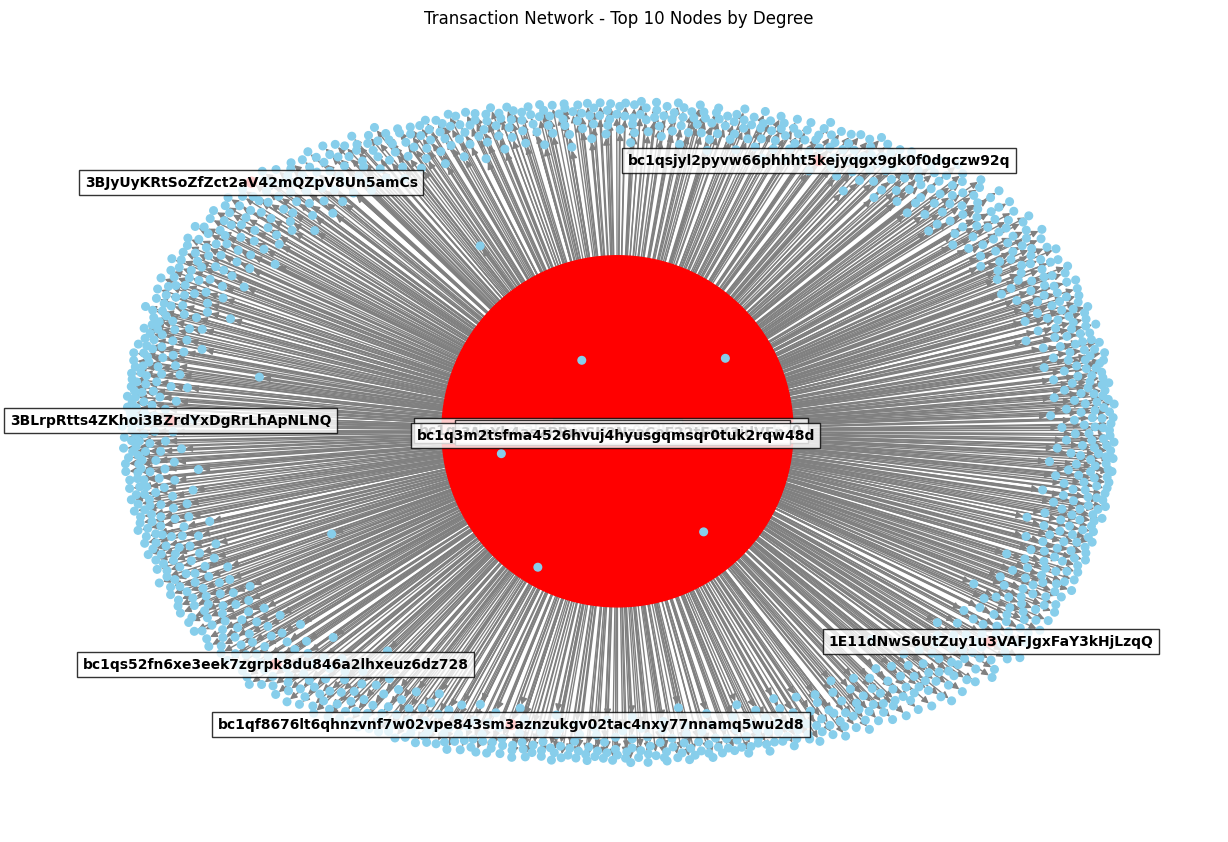


Descriptive Statistics by Wallet Address:
                                            total_transactions total_incoming  \
wallet_address                                                                 
bc1qt7fhd9dr3k67hjaycu0e09dkt829scxwvhxh20             100.00     4792048.12   

                                           total_outgoing  \
wallet_address                                              
bc1qt7fhd9dr3k67hjaycu0e09dkt829scxwvhxh20      105360.70   

                                           avg_transaction_size  \
wallet_address                                                    
bc1qt7fhd9dr3k67hjaycu0e09dkt829scxwvhxh20             48974.09   

                                           min_transaction_size  \
wallet_address                                                    
bc1qt7fhd9dr3k67hjaycu0e09dkt829scxwvhxh20                 0.82   

                                           max_transaction_size  \
wallet_address                                              

<ipython-input-17-56e77667ce7c>:115: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = stats.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)


In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import networkx as nx
from datetime import datetime
from adjustText import adjust_text

# Ensure float formatting
pd.set_option('display.float_format', '{:.6f}'.format)

# Function to get the conversion rate from BTC to USD using the CoinGecko API
def get_btc_to_usd_conversion_rate():
    url = "https://api.coingecko.com/api/v3/simple/price?ids=bitcoin&vs_currencies=usd"
    response = requests.get(url)
    if response.status_code == 200:
        btc_price = response.json().get('bitcoin', {}).get('usd', None)
        return btc_price
    return None

# Function to retrieve the last 100 transactions for the target address
def get_transactions(address, limit=100):
    base_url = 'https://btcscan.org/api'
    txs_endpoint = f'/address/{address}/txs/chain'
    all_transactions = []
    last_seen_txid = ''

    while len(all_transactions) < limit:
        url = f"{base_url}{txs_endpoint}"
        if last_seen_txid:
            url += f'/{last_seen_txid}'

        response = requests.get(url)
        if response.status_code != 200:
            break
        transactions = response.json()
        if not transactions:
            break
        all_transactions.extend(transactions[:limit - len(all_transactions)])
        last_seen_txid = transactions[-1]['txid']
        if len(transactions) < 25:
            break

    return all_transactions[:limit]

# Function to extract addresses involved in the transactions and prepare data for analysis
def extract_addresses(transactions, target_address):
    involved_addresses = []
    transactions_data = []
    btc_to_usd_rate = get_btc_to_usd_conversion_rate()
    if btc_to_usd_rate is None:
        print("Error: Unable to fetch BTC to USD conversion rate.")
        return [], []

    for tx in transactions:
        txid = tx['txid']
        tx_time = datetime.fromtimestamp(tx['status']['block_time'])
        tx_addresses = set()
        direction = None

        # Check inputs
        for vin in tx['vin']:
            amount_satoshi = vin['prevout']['value']
            amount_btc = amount_satoshi / 1e8
            amount_usd = amount_btc * btc_to_usd_rate
            vin_address = vin['prevout'].get('scriptpubkey_address')
            if vin_address == target_address:
                direction = "Outgoing"
            tx_addresses.add((vin_address, direction))

        # Check outputs
        for vout in tx['vout']:
            amount_satoshi = vout['value']
            amount_btc = amount_satoshi / 1e8
            amount_usd = amount_btc * btc_to_usd_rate
            vout_address = vout.get('scriptpubkey_address')
            if vout_address == target_address:
                direction = "Incoming"
            tx_addresses.add((vout_address, direction))

        involved_addresses.extend(tx_addresses)

        transactions_data.append({
            'txid': txid,
            'time': tx_time,
            'direction': direction,
            'amount_satoshi': amount_satoshi,
            'amount_btc': amount_btc,
            'amount_usd': amount_usd,
            'wallet_address': target_address
        })

    return involved_addresses, transactions_data

# Function to generate descriptive statistics for wallet addresses
def generate_descriptive_stats(transactions_data):
    df = pd.DataFrame(transactions_data)

    # Group by wallet address
    grouped = df.groupby('wallet_address')

    # Calculate descriptive stats
    stats = grouped.agg(
        total_transactions=('txid', 'count'),
        total_incoming=('amount_usd', lambda x: x[df['direction'] == 'Incoming'].sum()),
        total_outgoing=('amount_usd', lambda x: x[df['direction'] == 'Outgoing'].sum()),
        avg_transaction_size=('amount_usd', 'mean'),
        min_transaction_size=('amount_usd', 'min'),
        max_transaction_size=('amount_usd', 'max')
    )

    stats['total_money_flow'] = stats['total_incoming'] + stats['total_outgoing']

    # Format all float values with 2 decimal places
    stats = stats.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

    print("\nDescriptive Statistics by Wallet Address:\n", stats)
    return stats

# Function to plot the network graph
def plot_network_graph(involved_addresses):
    G = nx.DiGraph()

    # Add edges to the graph based on incoming and outgoing transactions
    for addr, direction in involved_addresses:
        if direction == "Outgoing":
            G.add_edge(addr, "Target Address")
        elif direction == "Incoming":
            G.add_edge("Target Address", addr)

    # Calculate the degree for each node (total incoming + outgoing transactions)
    degree = dict(G.degree())

    # Sort nodes by degree and select the top 10
    top_nodes = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:10]

    # Create a list of top addresses
    top_addresses = [node for node, _ in top_nodes]

    print("Top 10 Nodes with highest transactions with our target address:")
    for i, node in enumerate(top_addresses, 1):
        print(f"{i}. {node}")

    pos = nx.spring_layout(G, seed=42)  # Use a seed for consistent layout
    plt.figure(figsize=(12, 8))

    # Draw the graph with reduced node sizes
    nx.draw(G, pos, with_labels=False,
            node_size=[(degree[node] * 50) if node in top_addresses else 30 for node in G.nodes()],
            node_color=["red" if node in top_addresses else "skyblue" for node in G.nodes()],
            edge_color="gray")

    for node in top_addresses:
        x, y = pos[node]
        plt.text(x, y, node, fontsize=10, fontweight="bold", ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))

    plt.title("Transaction Network - Top 10 Nodes by Degree")
    plt.show()

# Main function to run the analysis
def main():
    address = 'bc1qt7fhd9dr3k67hjaycu0e09dkt829scxwvhxh20'  # Replace with your target address
    transactions = get_transactions(address)

    if transactions:
        involved_addresses, transactions_data = extract_addresses(transactions, address)

        print(f"Total transactions analyzed: {len(transactions)}")

        # Plot the network graph
        plot_network_graph(involved_addresses)

        # Generate descriptive statistics
        stats = generate_descriptive_stats(transactions_data)

        # Save descriptive stats to CSV with float formatting
        stats.to_csv("btc_wallet_stats.csv", index=True, float_format="%.2f")
        print("Descriptive statistics saved to btc_wallet_stats.csv")

    else:
        print("No transactions found.")

if __name__ == "__main__":
    main()


Fetched 25 transactions, Total: 25
Fetched 25 transactions, Total: 50
Fetched 25 transactions, Total: 75
Fetched 25 transactions, Total: 100
Fetched 25 transactions, Total: 125
Fetched 25 transactions, Total: 150
Fetched 25 transactions, Total: 175
Fetched 2 transactions, Total: 177
Total transactions analyzed: 177
Top 10 Nodes with highest transactions with our target address:
1. Target Address
2. bc1q0kpk303cljyn62vgve34hcxlztn7zfmh0jgjtf
3. 3AqYh4as2PRurSK2NzaCeF22tEaX3jdVEp
4. bc1q5kx8976cz6k3dhlcyht0znh22gr754uygq8xhl
5. bc1qqs0wd0p428q7ruv7fcynmdk3yvj2w8yaz3k2yf
6. bc1qe7dmkl2pnn27hdqv8kh7ynnpatku2njlxlwxfl
7. 38UFCaVsTK8YA4vkqYS9YcNANUB1JSJrp9
8. bc1qwpfrm4pqzs7ukda2kej25a5ztq9qm9n66fd6xp
9. 1QJTdE3UCGgeZQhRRYGxudApbKnXGA16NZ
10. 1EoZmAdooLvZ2CjGvoManqVKbuiQF7BoQC


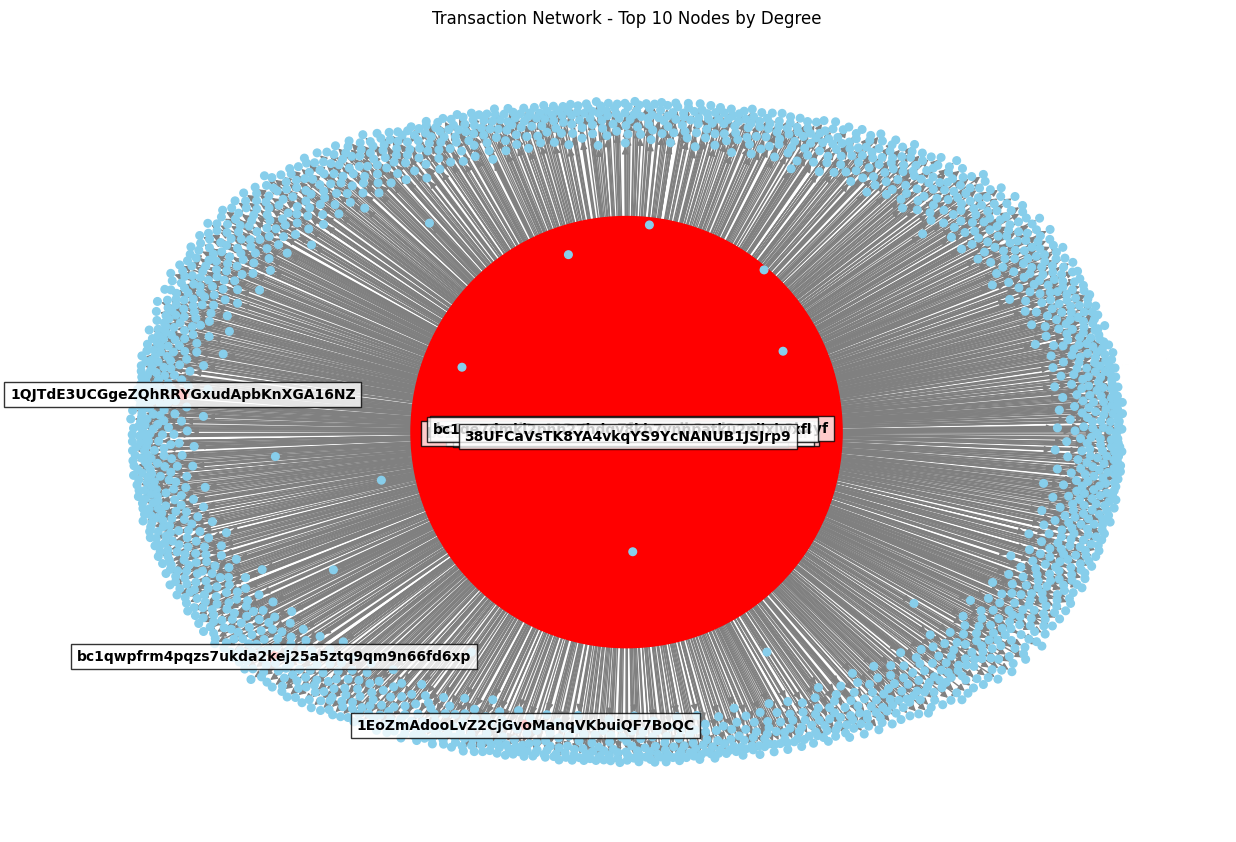


Descriptive Statistics by Wallet Address:
                                            total_transactions total_incoming  \
wallet_address                                                                 
bc1q0kpk303cljyn62vgve34hcxlztn7zfmh0jgjtf             177.00   154110090.14   

                                           total_outgoing  \
wallet_address                                              
bc1q0kpk303cljyn62vgve34hcxlztn7zfmh0jgjtf      136796.61   

                                           avg_transaction_size  \
wallet_address                                                    
bc1q0kpk303cljyn62vgve34hcxlztn7zfmh0jgjtf            871451.34   

                                           min_transaction_size  \
wallet_address                                                    
bc1q0kpk303cljyn62vgve34hcxlztn7zfmh0jgjtf                 0.96   

                                           max_transaction_size  \
wallet_address                                              

<ipython-input-18-c9541e6ebb4d>:125: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = stats.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)


In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import networkx as nx
from datetime import datetime
from adjustText import adjust_text

# Ensure float formatting
pd.set_option('display.float_format', '{:.6f}'.format)

# Function to get the conversion rate from BTC to USD using the CoinGecko API
def get_btc_to_usd_conversion_rate():
    url = "https://api.coingecko.com/api/v3/simple/price?ids=bitcoin&vs_currencies=usd"
    response = requests.get(url)
    if response.status_code == 200:
        btc_price = response.json().get('bitcoin', {}).get('usd', None)
        return btc_price
    return None

# Function to retrieve ALL transactions for the target address
def get_all_transactions(address):
    base_url = 'https://btcscan.org/api'
    txs_endpoint = f'/address/{address}/txs/chain'
    all_transactions = []
    last_seen_txid = ''

    # Fetch transactions in batches until no more are returned
    while True:
        url = f"{base_url}{txs_endpoint}"
        if last_seen_txid:
            url += f'/{last_seen_txid}'  # Continue from the last seen transaction

        response = requests.get(url)
        if response.status_code != 200:
            print(f"Error: API request failed with status code {response.status_code}")
            break

        transactions = response.json()

        # Break the loop if no more transactions are found
        if not transactions:
            break

        all_transactions.extend(transactions)
        last_seen_txid = transactions[-1]['txid']  # Keep track of the last seen transaction ID

        print(f"Fetched {len(transactions)} transactions, Total: {len(all_transactions)}")

        # Stop if the API returns fewer than a full batch (assuming batch size is 25)
        if len(transactions) < 25:
            break

    return all_transactions

# Function to extract addresses involved in the transactions and prepare data for analysis
def extract_addresses(transactions, target_address):
    involved_addresses = []
    transactions_data = []
    btc_to_usd_rate = get_btc_to_usd_conversion_rate()
    if btc_to_usd_rate is None:
        print("Error: Unable to fetch BTC to USD conversion rate.")
        return [], []

    for tx in transactions:
        txid = tx['txid']
        tx_time = datetime.fromtimestamp(tx['status']['block_time'])
        tx_addresses = set()
        direction = None

        # Check inputs
        for vin in tx['vin']:
            amount_satoshi = vin['prevout']['value']
            amount_btc = amount_satoshi / 1e8
            amount_usd = amount_btc * btc_to_usd_rate
            vin_address = vin['prevout'].get('scriptpubkey_address')
            if vin_address == target_address:
                direction = "Outgoing"
            tx_addresses.add((vin_address, direction))

        # Check outputs
        for vout in tx['vout']:
            amount_satoshi = vout['value']
            amount_btc = amount_satoshi / 1e8
            amount_usd = amount_btc * btc_to_usd_rate
            vout_address = vout.get('scriptpubkey_address')
            if vout_address == target_address:
                direction = "Incoming"
            tx_addresses.add((vout_address, direction))

        involved_addresses.extend(tx_addresses)

        transactions_data.append({
            'txid': txid,
            'time': tx_time,
            'direction': direction,
            'amount_satoshi': amount_satoshi,
            'amount_btc': amount_btc,
            'amount_usd': amount_usd,
            'wallet_address': target_address
        })

    return involved_addresses, transactions_data

# Function to generate descriptive statistics for wallet addresses
def generate_descriptive_stats(transactions_data):
    df = pd.DataFrame(transactions_data)

    # Group by wallet address
    grouped = df.groupby('wallet_address')

    # Calculate descriptive stats
    stats = grouped.agg(
        total_transactions=('txid', 'count'),
        total_incoming=('amount_usd', lambda x: x[df['direction'] == 'Incoming'].sum()),
        total_outgoing=('amount_usd', lambda x: x[df['direction'] == 'Outgoing'].sum()),
        avg_transaction_size=('amount_usd', 'mean'),
        min_transaction_size=('amount_usd', 'min'),
        max_transaction_size=('amount_usd', 'max')
    )

    stats['total_money_flow'] = stats['total_incoming'] + stats['total_outgoing']

    # Format all float values with 2 decimal places
    stats = stats.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

    print("\nDescriptive Statistics by Wallet Address:\n", stats)
    return stats

# Function to plot the network graph
def plot_network_graph(involved_addresses):
    G = nx.DiGraph()

    # Add edges to the graph based on incoming and outgoing transactions
    for addr, direction in involved_addresses:
        if direction == "Outgoing":
            G.add_edge(addr, "Target Address")
        elif direction == "Incoming":
            G.add_edge("Target Address", addr)

    # Calculate the degree for each node (total incoming + outgoing transactions)
    degree = dict(G.degree())

    # Sort nodes by degree and select the top 10
    top_nodes = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:10]

    # Create a list of top addresses
    top_addresses = [node for node, _ in top_nodes]

    print("Top 10 Nodes with highest transactions with our target address:")
    for i, node in enumerate(top_addresses, 1):
        print(f"{i}. {node}")

    pos = nx.spring_layout(G, seed=42)  # Use a seed for consistent layout
    plt.figure(figsize=(12, 8))

    # Draw the graph with reduced node sizes
    nx.draw(G, pos, with_labels=False,
            node_size=[(degree[node] * 50) if node in top_addresses else 30 for node in G.nodes()],
            node_color=["red" if node in top_addresses else "skyblue" for node in G.nodes()],
            edge_color="gray")

    for node in top_addresses:
        x, y = pos[node]
        plt.text(x, y, node, fontsize=10, fontweight="bold", ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))

    plt.title("Transaction Network - Top 10 Nodes by Degree")
    plt.show()

# Main function to run the analysis
def main():
    address = 'bc1q0kpk303cljyn62vgve34hcxlztn7zfmh0jgjtf'  # Replace with your target address
    transactions = get_all_transactions(address)

    if transactions:
        involved_addresses, transactions_data = extract_addresses(transactions, address)

        print(f"Total transactions analyzed: {len(transactions)}")

        # Plot the network graph
        plot_network_graph(involved_addresses)

        # Generate descriptive statistics
        stats = generate_descriptive_stats(transactions_data)

        # Save descriptive stats to CSV with float formatting
        stats.to_csv("btc_wallet_stats.csv", index=True, float_format="%.2f")
        print("Descriptive statistics saved to btc_wallet_stats.csv")

    else:
        print("No transactions found.")

if __name__ == "__main__":
    main()
